In [1]:
import re
import pandas as pd
import numpy as np
# import more_itertools as mit
# from datetime import datetime
import missingno as msngo
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
df = pd.read_excel('GranVolEjto-Vehiculo-02.xlsx', header=0)

In [3]:
print(*df.columns, sep=', ')

Nro Linea, Libro, Rubro Subrubro Especie, Rubro, Subrubro, Especie, Numero Activo, Descripcion, Numero Etiqueta, Fabricante, Numero Serie, Modelo, Tipo Activo, En uso, Propiedad, Comprado, Inventario Fisico, Fecha Inflacion, Unidad Asignada, UAC, UR, UC, UF, Fuente Financiamiento, Centro Financiero, Proyecto, Programa, Subprograma, Juego Atributo, ATT1, ATT2, ATT3, ATT4, ATT5, ATT6, ATT7, ATT8, ATT9, ATT10, ATT11, ATT12, ATT13, ATT14, ATT15, ATT16, ATT17, ATT18, ATT19, ATT20, ATT21, ATT22, ATT23, ATT24, ATT25, ATT26, ATT27, ATT28, ATT29, ATT30, Unnamed: 59


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9464 entries, 0 to 9463
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Nro Linea               9464 non-null   int64         
 1   Libro                   9464 non-null   object        
 2   Rubro Subrubro Especie  9464 non-null   int64         
 3   Rubro                   9464 non-null   int64         
 4   Subrubro                9464 non-null   int64         
 5   Especie                 9464 non-null   int64         
 6   Numero Activo           9464 non-null   int64         
 7   Descripcion             9464 non-null   object        
 8   Numero Etiqueta         9058 non-null   object        
 9   Fabricante              6379 non-null   object        
 10  Numero Serie            9155 non-null   object        
 11  Modelo                  9296 non-null   object        
 12  Tipo Activo             9464 non-null   object  

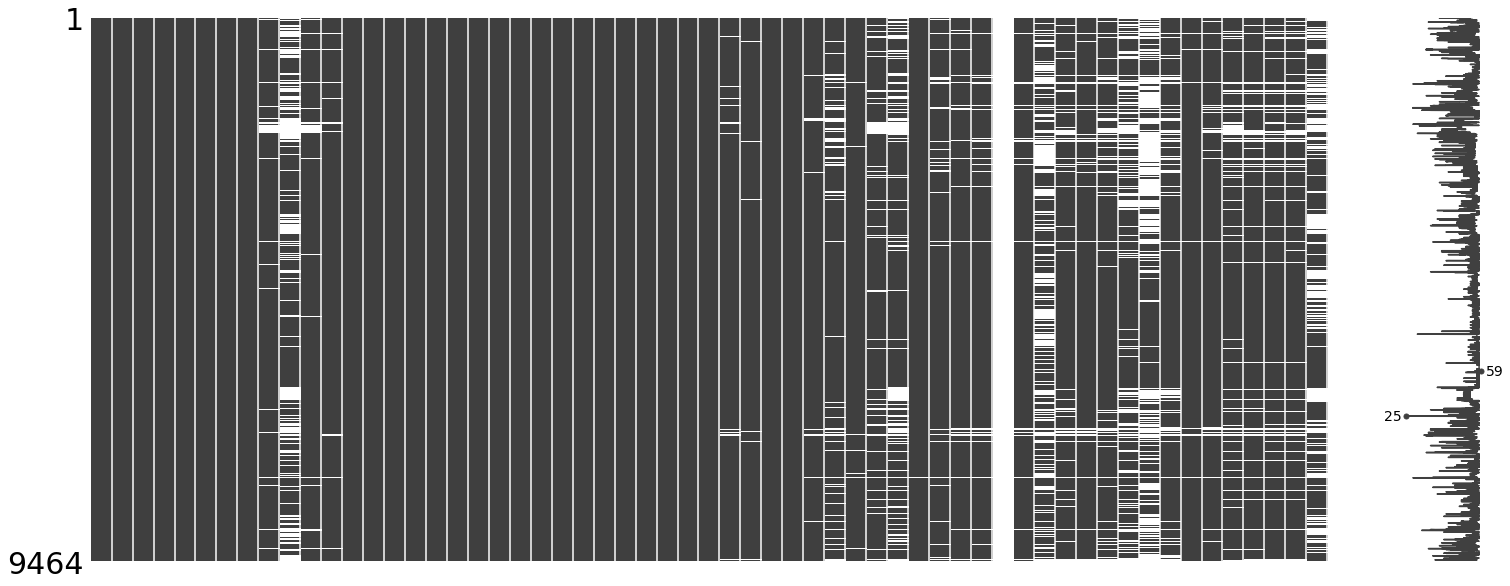

In [5]:
# df.head()
mat = msngo.matrix(df)
mat.axes.tick_params(axis='y', labelsize=30)

In [6]:
df_rs = df[['Numero Etiqueta', 'Descripcion', 'ATT8', 'Modelo', 'UAC', 'UR', 'ATT11', 'ATT19', 'ATT24']]
df_rs = df_rs.drop_duplicates()
df_rs.reset_index(drop=True, inplace=True)

In [7]:
df_rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9241 entries, 0 to 9240
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Numero Etiqueta  9058 non-null   object
 1   Descripcion      9241 non-null   object
 2   ATT8             9176 non-null   object
 3   Modelo           9104 non-null   object
 4   UAC              9241 non-null   object
 5   UR               9241 non-null   object
 6   ATT11            9192 non-null   object
 7   ATT19            8801 non-null   object
 8   ATT24            9122 non-null   object
dtypes: object(9)
memory usage: 649.9+ KB


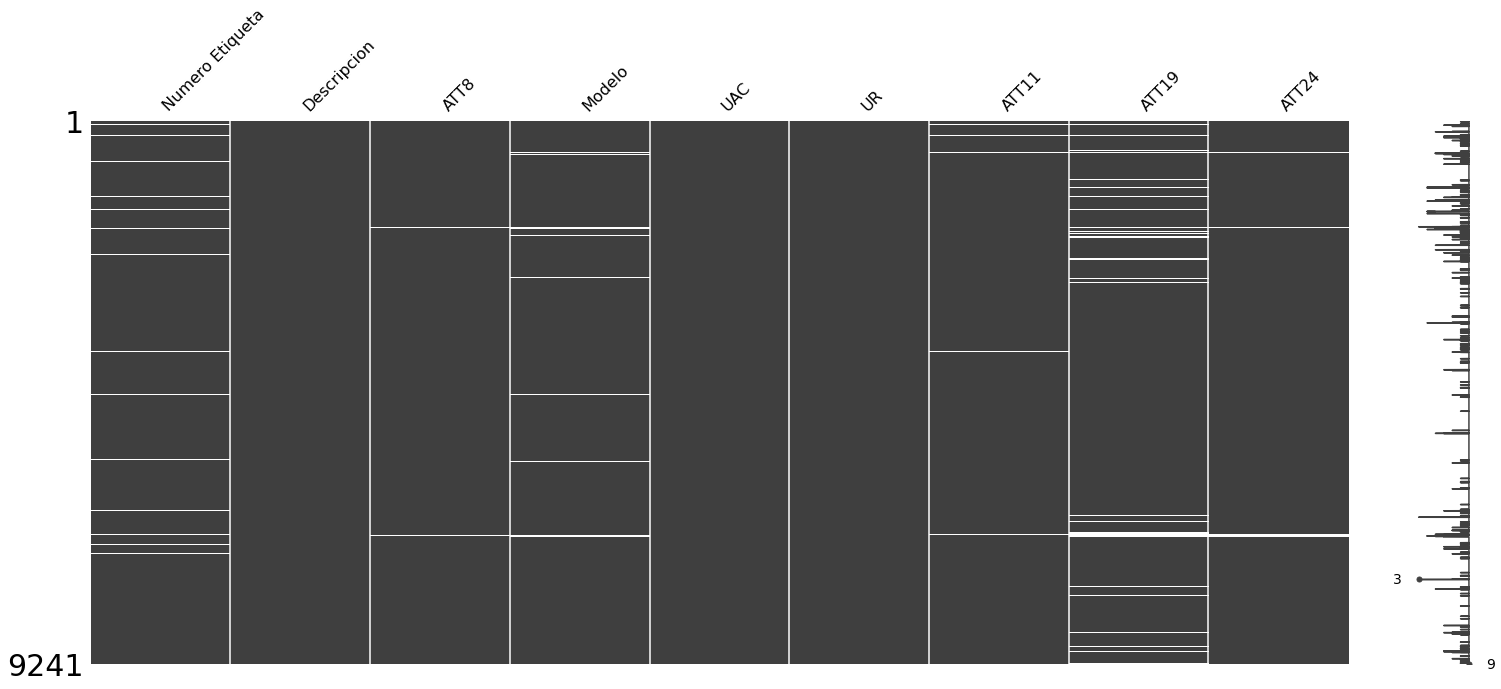

In [8]:
mat = msngo.matrix(df_rs)
mat.axes.tick_params(axis='y', labelsize=30)

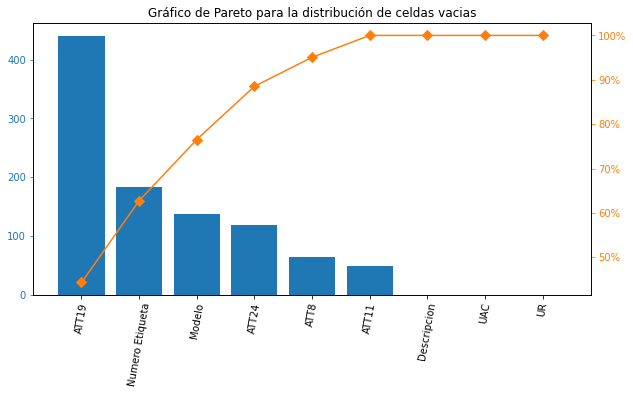

In [9]:
data_cvo = df_rs.isna().sum().sort_values(ascending=False)
df = pd.DataFrame({'columna': data_cvo.values})
df.index = data_cvo.index
df = df.sort_values(by='columna',ascending=False)
df["cumper"] = df["columna"].cumsum()/df["columna"].sum()*100


fig, ax = plt.subplots(figsize=(10,5))
ax.bar(df.index, df["columna"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumper"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax.tick_params(axis="x", rotation=80)
ax2.tick_params(axis="y", colors="C1")
plt.title('Gráfico de Pareto para la distribución de celdas vacias')
plt.show()

In [10]:
# df_rs['test'] = []
df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains('\*'),1 , 0)
df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains(' '),1 , df_rs['test'])
# df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains('.'),1 , df_rs['test'])
df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains('REP.'),1 , df_rs['test'])
df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains('XW6996'),1 , df_rs['test'])
df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains('SINMATRICULA'),1 , df_rs['test'])
df_rs['test'] = np.where(df_rs['Numero Etiqueta'].str.contains('S/M'),1 , df_rs['test'])

print('Numero de errores a correguir '+str(df_rs['test'].value_counts()[1]))

df_rs.drop(columns='test', inplace=True)

Numero de errores a correguir 291


In [11]:
# %%time
chars_to_remove = ['*', ' ']
regular_expression = '[' + re.escape (''. join (chars_to_remove)) + ']'

df_rs['Numero Etiqueta'] = df_rs['Numero Etiqueta'].str.replace(regular_expression,'', regex=True)
df_rs['Numero Etiqueta'] = df_rs['Numero Etiqueta'].str.replace('.','-', regex=True)
df_rs['Numero Etiqueta'] = df_rs['Numero Etiqueta'].str.replace('REP.','', regex=True)
df_rs['Numero Etiqueta'] = df_rs['Numero Etiqueta'].str.replace('XW6996','XW-6996', regex=True)
df_rs['Numero Etiqueta'] = df_rs['Numero Etiqueta'].str.replace('SINMATRICULA','', regex=True)
df_rs['Numero Etiqueta'] = df_rs['Numero Etiqueta'].str.replace('S/M','', regex=True)

b=0
for i, n in enumerate(df_rs['Numero Etiqueta']):
    try:
        a = n.split('-')
        if len(a) > 2:
            if (re.match(r'[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{0}$', n)):
                df_rs.loc[i, 'Numero Etiqueta'] = n[:-1]
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1}$', n)):
                df_rs.loc[i, 'Numero Etiqueta'] = n[:-2]    
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{2}$', n)):
                df_rs.loc[i, 'Numero Etiqueta'] = n[:-3]
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{3}$', n)):
                df_rs.loc[i, 'Numero Etiqueta'] = n[:-4]
                b=b+1
            if (re.match(r'[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}-[a-zA-Z0-9]{1, 4}$', n)):
                df_rs.loc[i, 'Numero Etiqueta'] = n[:-3]
                b=b+1
    except:
        b=b+0

print('Errores relacionados a Patentes mal ingresadas '+str(b))

df_rs.drop_duplicates(subset='Numero Etiqueta', ignore_index=True, inplace=True)
# df_rs.reset_index(drop=True, inplace=True)
# df_rs

Errores relacionados a Patentes mal ingresadas 0


In [12]:
df_rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8988 entries, 0 to 8987
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Numero Etiqueta  8987 non-null   object
 1   Descripcion      8988 non-null   object
 2   ATT8             8938 non-null   object
 3   Modelo           8894 non-null   object
 4   UAC              8988 non-null   object
 5   UR               8988 non-null   object
 6   ATT11            8962 non-null   object
 7   ATT19            8628 non-null   object
 8   ATT24            8904 non-null   object
dtypes: object(9)
memory usage: 632.1+ KB


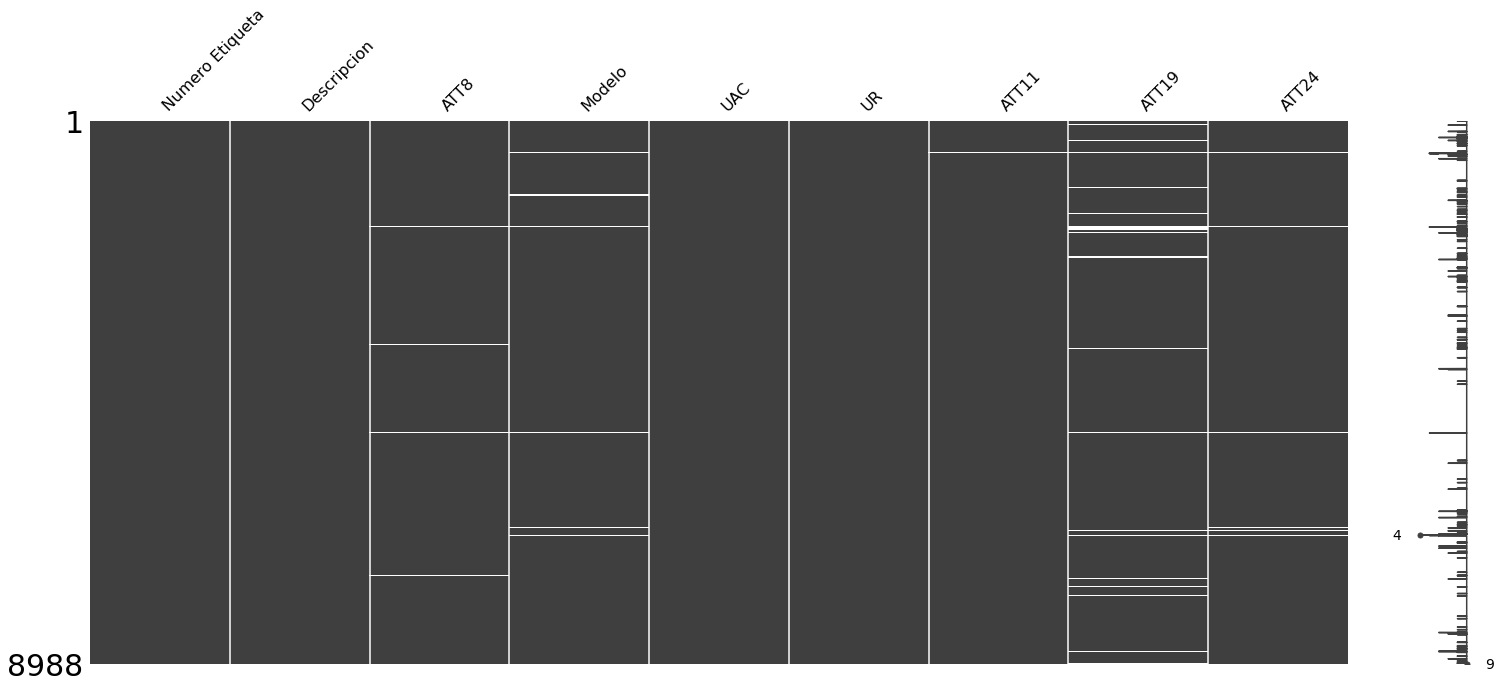

In [13]:
mat = msngo.matrix(df_rs)
mat.axes.tick_params(axis='y', labelsize=30)

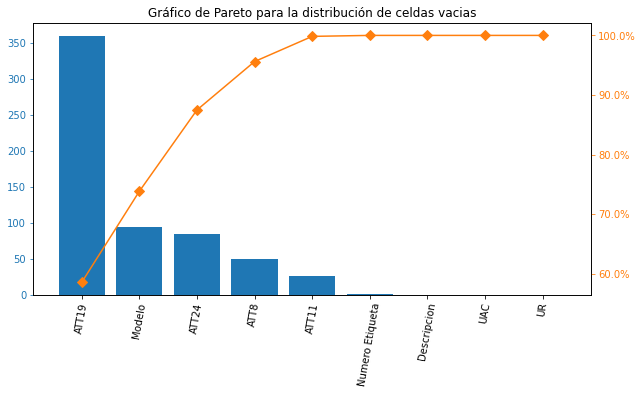

In [14]:
data_cvo = df_rs.isna().sum().sort_values(ascending=False)
df = pd.DataFrame({'columna': data_cvo.values})
df.index = data_cvo.index
df = df.sort_values(by='columna',ascending=False)
df["cumper"] = df["columna"].cumsum()/df["columna"].sum()*100


fig, ax = plt.subplots(figsize=(10,5))
ax.bar(df.index, df["columna"], color="C0")
ax2 = ax.twinx()
ax2.plot(df.index, df["cumper"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax.tick_params(axis="x", rotation=80)
ax2.tick_params(axis="y", colors="C1")
plt.title('Gráfico de Pareto para la distribución de celdas vacias')
plt.show()

In [15]:
# df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('ALJIBE PARA AGUA','REMOLQUE ALJIBE', regex=False)
# df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('MINI CARGADOR','MINICARGADOR', regex=False)
# df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('MONTACARGA CON HORQUILLA','MONTACARGA', regex=False)
# df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('MOTO DE NIEVE','MOTO PARA NIEVE', regex=False)
# df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('STATION WAGON','SUV', regex=False)

In [16]:
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('ALJIBE PARA AGUA','REMOLQUE ALJIBE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('MINI CARGADOR','MINICARGADOR', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('MONTACARGA CON HORQUILLA','MONTACARGA', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('MOTO PARA NIEVE','MOTO DE NIEVE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('STATION WAGON','SUV', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('SEMIREMOLQUE CAMA BAJA','SEMIREMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('SEMIREMOLQUE EQUIPO LOGISTICO','SEMIREMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('SEMIREMOLQUE DE CARGA','SEMIREMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE DE CARGA','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE ESTANQUE','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE PARA USO EN NIEVE','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE EQUIPO LOGISTICO','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE ALJIBE','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE LIVIANO','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE TRIPLE (MOTOCICLETA)','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE TRIPLE','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE DE ARRASTRE ANIMAL (USO AGRICOLA)','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE MB 2300W','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE PESADO','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE CARGA (CUADRIMOTO)','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('TRINEO DE ARRASTRE PARA MOTO DE NIEVE','TRINEO DE ARRASTRE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('TRINEO DE ARRASTRE ORION PARA MOTO DE NIEVE','TRINEO DE ARRASTRE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('TRACTOR AGRICOLA','TRACTOR', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMIONETA DE TRASNPORTE PERSONAL','CAMIONETA', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMIONETA TRASNPORTE PERSONAL','CAMIONETA', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMIONETA TRASNPORTE SHELTER','CAMIONETA', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMIÓN','CAMION', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMION TRASNPORTE SHELTER','CAMION', regex=False)
# df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMIÓN TRASNPORTE SHELTER','CAMION', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMION TRANSPORTE SHELTER','CAMION', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('JEEP DE TRASNPORTE','JEEP', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMIONETA PARA ESTACION REPETIDORA','CAMIONETA', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('REMOLQUE ALGIBE','REMOLQUE', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace(' CAMA BAJA ','CAMA BAJA', regex=False)
df_rs['Descripcion'] = df_rs['Descripcion'].str.replace('CAMION DE TRANSPORTE','CAMION', regex=False)

In [17]:
df_rs['ATT8'] = df_rs['ATT8'].str.replace('ALTO AMERICAN- LINCOLN','AMERICAN LINCOLN', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('AM GENERAL','AM GEN', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('AM GEN','AM GENERAL', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('ASIA MOTORS','ASIA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('ASIA','ASIA MOTORS', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BARRETT','BARRET', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BARRET','BARRETT', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BEIT ALFA TRAILER CO','BEIT ALFA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BEIT-ALFA TRAILER CO.','BEIT ALFA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BLUMHART','BLUMHARDT', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BOBCAT INGERSOLL RAND','BOBCAT', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BOBCAT MODELO S630 FULLJ','BOBCAT', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BOMBARDIER BRP SKI DOO','BOMBARDIER', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BOX/CB2.SANCHEZ/Balatas,Neumaticos,Correa distribucion y turbo con eje gastados','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('BROCK HOUSE','BROCKHOUSE', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('CARDOEN','CARDOEN-MOWAG', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('CATARPILLAR','CATERPILLAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('CATERPILAR','CATERPILLAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('CATERPILLAR 130-G','CATERPILLAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('CATERPILLAR D6D','CATERPILLAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('COMAND CAR','COMMANDCAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('COMANDCAR','COMMANDCAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('COMMANCAR','COMMANDCAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('COMMAND CAR','COMMANDCAR', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('CUSTROM','CUSTOM', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('DAHIATSU','DAIHATSU', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('FDERAL MOTOR COMPANY','FEDERAL MOTOR COMPANY', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('FEDERAL MOTOR COMPANY','FEDERAL', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('FEDERAL','FEDERAL MOTOR COMPANY', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('FMC CORPORATION','FEDERAL MOTOR COMPANY', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('FORD RANGER','FORD', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('HYNDAI','HYUNDAI', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('HYUNDAY','HYUNDAI', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('HYUYNDAI','HYUNDAI', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('ELANTRA','HYUNDAI', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('INCA FREUHAUF','INCA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('INCA FRUEHAUF','INCA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('ISUSU','ISUZU', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('IZUSU','ISUZU', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('JOHNSON','TEST', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('JHON DEERE','JOHN', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('JOHN DEERE','JOHN', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('JHON DEER','JOHN', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('JOHN','JOHN DEERE', regex=False)
# df_rs['ATT8'] = df_rs['ATT8'].str.replace('JOHN','JOHN DEEREE', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('TEST','JOHNSON', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('KIA MOTORS','KIA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('KIA SORENTO','KIA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('KOMATSU PC 130-8','KOMATSU', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('M/BENZ','MERCEDES BENZ', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('MERC. BENZ','MERCEDES BENZ', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('MERCEDEZ BENZ','MERCEDES BENZ', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('MERCEDEZ-BENZ','MERCEDES BENZ', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('MERCEDES BENZ   ','MERCEDES BENZ', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('MAK','MACK', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('nissan','NISSAN', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('NETZER SERENI','NETZER', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('N.A','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('N.A.','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('SIM MARCA','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('SIN INFORMACION','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('SIN MARCA','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('NO APLICA','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('S/M','', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('POLARIS DEFENSE','POLARIS', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('POLARIS','DEFENSE', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('RANDOM','RANDON', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('TECNOVE SEGURITY','TECNOVE SECURITY', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('TOYOTA CAMRI','TOYOTA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('TOYOTA LAND CRUISER II','TOYOTA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('TOYOTA LAND CRUISER','TOYOTA', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('WILLYS BANTAM','WILLYS', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('SUZUKY','SUZUKI', regex=False)
df_rs['ATT8'] = df_rs['ATT8'].str.replace('ZUZUKI DR 350','SUZUKI', regex=False)

In [18]:
df_rs['ATT19']=np.where(df_rs['ATT19'].str.contains('DIESEL'), 'DIESEL', df_rs['ATT19'])
df_rs['ATT19']=np.where(df_rs['ATT19'].str.contains('BENCI'), 'BENCINERO', df_rs['ATT19'])
df_rs['ATT19']=np.where(df_rs['ATT19'].str.contains('NO APLICA'), 'NO APLICA', df_rs['ATT19'])
df_rs['ATT19']=np.where((df_rs['ATT19'].str.contains('NO APLICA')) | (df_rs['ATT19'].str.contains('DIESEL')) | (df_rs['ATT19'].str.contains('BENCI')), df_rs['ATT19'], 'NO APLICA')

In [19]:
df_test = df_rs.copy()

In [20]:
# df_test.drop_duplicates(subset='Numero Etiqueta', ignore_index=True, inplace=True)

In [21]:
# df_test.to_csv('Clean_Bd_Vehic.csv', encoding='latin-1')

out_file = Path.cwd() / "Clean_Bd_Vehic.xlsx"
writer = pd.ExcelWriter(out_file, engine = 'xlsxwriter')
df_test.to_excel(writer, index = False, sheet_name = 'Test1')
#df_vehic.to_excel(writer, index = False, sheet_name = 'Test2')
writer.save()